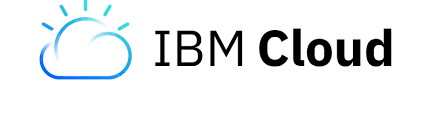

## Setup your notebook file stystem on Watson Studio

All of the notebooks in these courses are written to run locally on your computer running a Jupyter notebook server.  If you wish to run the notebooks in Watson Studio in the IBM Cloud, you will need to add some modifications to each notebook.

Why?  Because once you import a course notebook and the data files for that notebook into a Watson Studio project, the data files are no longer available to the notebook! 
This is simply due to the fact that the imported data files are stored in an IBM Cloud Object Storage (COS) bucket.  The notebook does not have access to those objects in the COS bucket.  Thus, if you import a notebook and its data files into a Studio project then try to run it, the notebook will return "File not found" errors. 
In order to make the data files available to your notebook, you will need to run some code in your notebook to: 

1 - Access the correct COS bucket <br>
2 - Read your data file from the bucket into a byte stream object <br>
3 - Write that byte stream object to the virtual disk of the container running the notebook. 

First, in order to access the correct COS bucket, you need to <b>insert a project token</b>. To do so, click the <b>More</b> icon on your notebook toolbar and then click <b>Insert project token</b>.

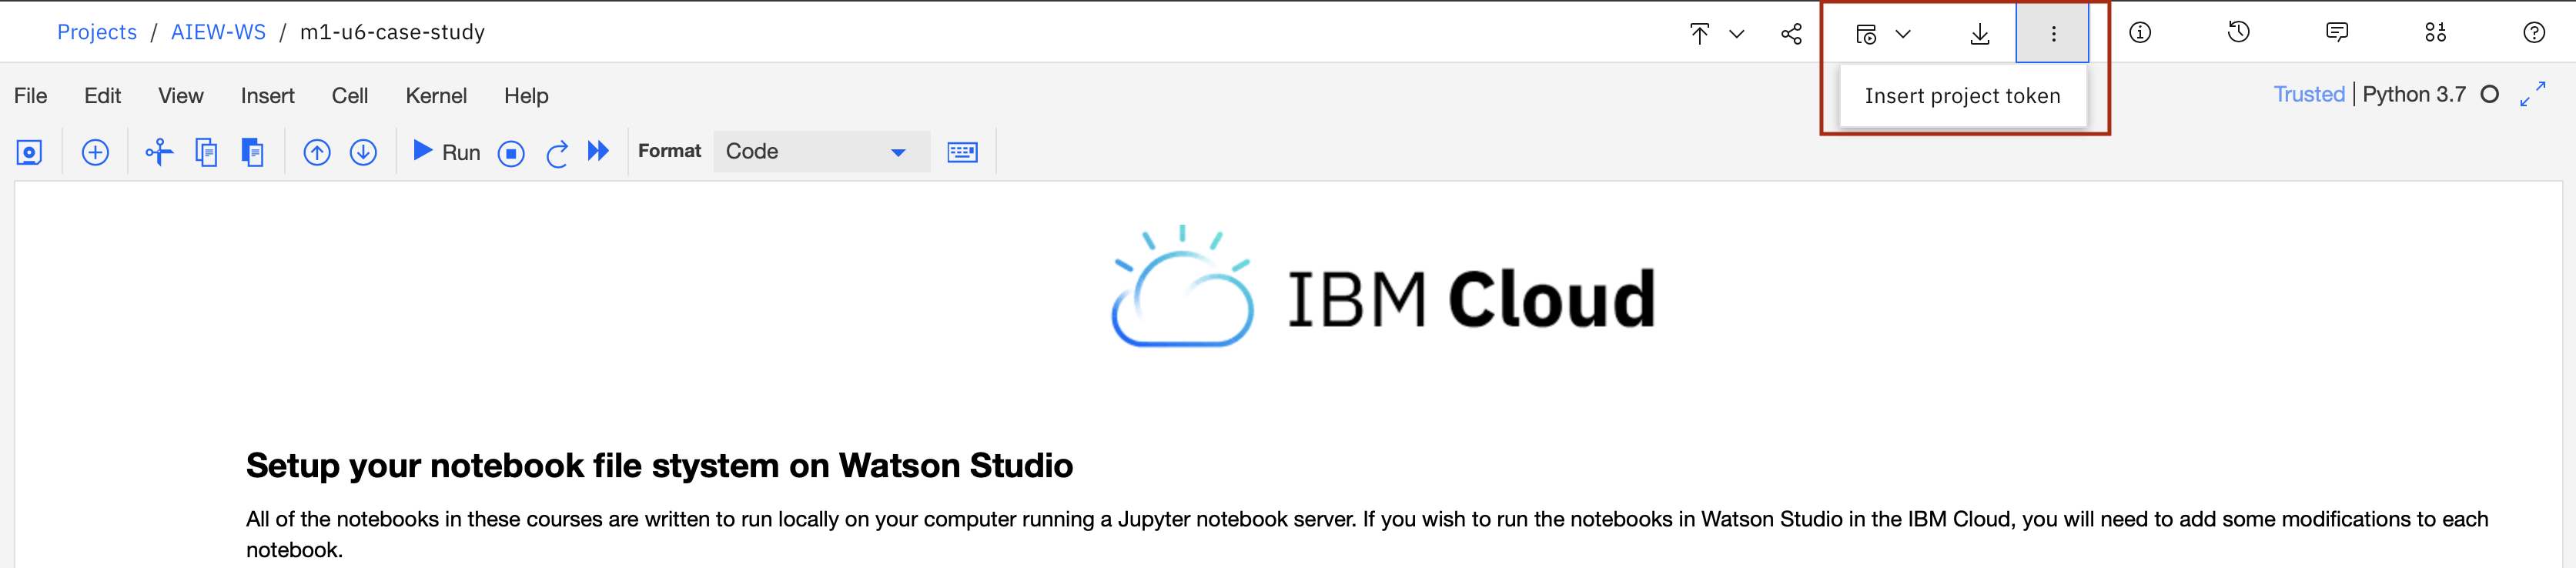

A new cell will be added on top of your notebook. Running this cell allows to create the <b>"project"</b> object that will allow us to access the COS bucket. After running this new cell, run the following two coding cells to write the data files in the virtual disk of the container running this notebook. You are ready to start the study case !

In [ ]:
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

In [ ]:
# Calling cos2file allows to make the data files available to the notebook 
cos2file(project, '/data', 'movie_reviews.csv')



# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [ ]:
! pip install pyLDAvis
! pip install spacy

In [ ]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [ ]:
filename = os.path.join(DATA_DIR, "movie_reviews.csv")
df = pd.read_csv(filename)
X = df['review'].tolist()
print(X[4])

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [ ]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)
        doc = doc.replace('\\n','')
        doc = doc.replace('\\t','')

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

In [ ]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.
processed = 
print("processing done.")

### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [ ]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = 

# Fit and transform this object to the processed reviews
tf = 
print("ready")

### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [ ]:
## YOUR CODE HERE
n_topics = 10

# Create an LDA object
lda_model = 

# Fit the model to the bag of word we created earlier


## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [ ]:
## YOUR CODE HERE


## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [ ]:
## YOUR CODE HERE

# set the number of topics
n_topics = 7

# Create the LDA model
lda_model = 

# fit and transform the LDA model to the vecotrized corpus
lda_transformed = 

# use the pyLDAvis to visualise the topics


The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [ ]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [ ]:
## YOUR CODE HERE

## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = 

## get the top words for each topic
top_words = 

## print the topics and the top words of each topic


## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

In [ ]:
## YOUR CODE HERE
